# Dependencies

In [526]:
import numpy as np
import pandas as pd # For working with spreadsheet data
from matplotlib import pyplot as plt # For plotting data
import matplotlib.dates as mdates
import math # For splitting the data into different sets for the NN
import datetime # Converting dates in the DataFrame into integers

from sklearn.model_selection import train_test_split # For separating the data into training and testing sets
from sklearn.preprocessing import MinMaxScaler # For preprocessing the data before it's passed to the model
from sklearn.svm import SVR # One of the algorithms being used to forecast the price
from sklearn.model_selection import cross_val_score # Metric to test the model's accuracy when hyperparameter tuning
from sklearn.metrics import mean_squared_error, r2_score # Metrics to see the model's accuracy after it's been trained

# For the deep learning model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam

# For hyperparameter optimization
import optuna

# For saving the neural network weights
import os

# Loading the Data

In [431]:
# Getting the spreadsheet data
data = pd.read_csv("Ethereum Data/ETH_5Years.csv")

In [231]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,197.380997,1442380000
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,198.871994,1336700000
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,200.634995,1451870000
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,200.186005,1307150000
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,207.485992,1749300000
...,...,...,...,...,...,...,...
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,1780.045288,7493399771
1823,2023-10-28,1780.084229,1800.605347,1773.436646,1776.618164,1776.618164,4226112731
1824,2023-10-29,1776.563965,1810.488647,1766.052979,1795.546021,1795.546021,4358528382
1825,2023-10-30,1795.589111,1829.249512,1779.364502,1810.088623,1810.088623,7534051038


# Cleaning the Data

In [432]:
# Deleting this row since it isn't important here
data.drop(['Adj Close'], axis = 1, inplace = True)

In [233]:
data

,Date,Open,High,Low,Close,Volume
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,1442380000
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,1336700000
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,1451870000
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,1307150000
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,1749300000
...,...,...,...,...,...,...
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,7493399771
1823,2023-10-28,1780.084229,1800.605347,1773.436646,1776.618164,4226112731
1824,2023-10-29,1776.563965,1810.488647,1766.052979,1795.546021,4358528382
1825,2023-10-30,1795.589111,1829.249512,1779.364502,1810.088623,7534051038


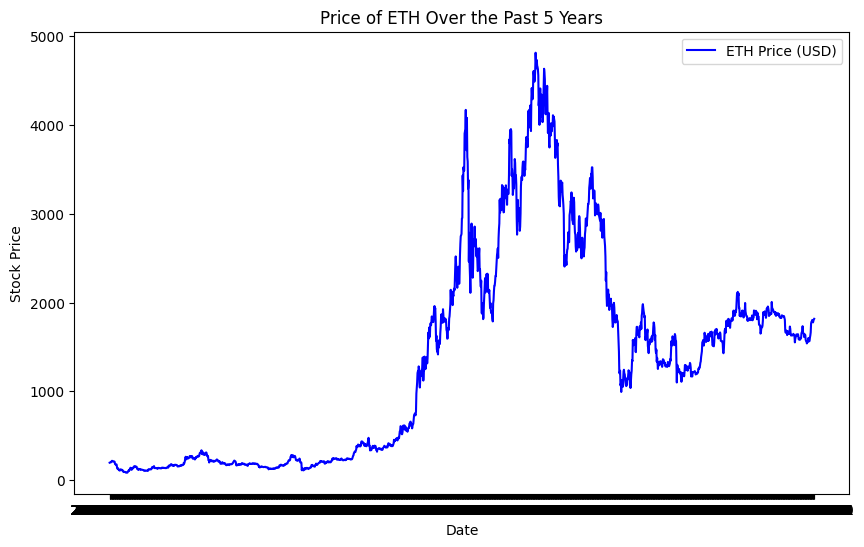

In [234]:
# Plotting ETH price
plt.figure(figsize = (10, 6))
plt.plot(data['Date'], data['Close'], label = "ETH Price (USD)", color = "blue")

plt.title("Price of ETH Over the Past 5 Years")
plt.xlabel("Date")
plt.xticks()
plt.ylabel("Stock Price")
plt.legend()

plt.show()

In [235]:
data['Close']

0        197.380997
1        198.871994
2        200.634995
3        200.186005
4        207.485992
           ...     
1822    1780.045288
1823    1776.618164
1824    1795.546021
1825    1810.088623
1826    1816.458984
Name: Close, Length: 1827, dtype: float64

In [236]:
data

,Date,Open,High,Low,Close,Volume
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,1442380000
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,1336700000
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,1451870000
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,1307150000
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,1749300000
...,...,...,...,...,...,...
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,7493399771
1823,2023-10-28,1780.084229,1800.605347,1773.436646,1776.618164,4226112731
1824,2023-10-29,1776.563965,1810.488647,1766.052979,1795.546021,4358528382
1825,2023-10-30,1795.589111,1829.249512,1779.364502,1810.088623,7534051038


In [433]:
# Creating a constant to store the number of days in the future to predict the price
DAYS_IN_FUTURE = 3
length = len(data)

# Adding an extra column for the future price and setting the value of each row equal to the 'Close' value DAYS_IN_FUTURE days in the future
future_price = [data['Close'].loc[x + DAYS_IN_FUTURE] for x in range(length - DAYS_IN_FUTURE)]

# Getting rid of last DAYS_IN_FUTURE rows since there is no future price value for those days
for x in range(DAYS_IN_FUTURE):
    data.drop(length - x - 1, inplace = True)

In [434]:
# Creating the column in the DataFrame
data[f"{DAYS_IN_FUTURE} Days Future Price"] = future_price
data

,Date,Open,High,Low,Close,Volume,3 Days Future Price
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,1442380000,200.186005
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,1336700000,207.485992
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,1451870000,209.091003
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,1307150000,218.451996
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,1749300000,217.182999
...,...,...,...,...,...,...,...
1819,2023-10-24,1766.014648,1852.684448,1758.690063,1784.437500,15888690475,1780.045288
1820,2023-10-25,1784.905029,1814.484741,1762.147095,1787.397583,9439066475,1776.618164
1821,2023-10-26,1787.481934,1865.095215,1764.013062,1804.039307,11196672635,1795.546021
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,7493399771,1810.088623


# Preparing the Data

In [435]:
# Converting the date value to an integer so it can be used by the model
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].map(mdates.date2num)
# Storing the cleaned data so it can be used again in the LSTM model
cleaned_data = data

In [436]:
# Storing the independent variables and dependent variable
features = data[['Open', 'Date', 'Close']]
target = data[f'{DAYS_IN_FUTURE} Days Future Price'].values
# Reshaping the input data so it can be passed to the model
features = features.to_numpy()

In [437]:
# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.4)

In [ ]:
# y_train_reshaped = np.ravel(y_train)
# x_train

In [438]:
# Scale the features data for preprocessing
scaler = MinMaxScaler(feature_range = (0, 1))

# x_train = x_train.reshape(-1, 1)
# x_test = x_test.reshape(-1, 1)

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

# SVR Hyperparameter Optimization

In [439]:
# Train the SVR model in a way that optimizes the model's hyperparameters
def optimize_svr(trial):
    # Suggesting possible values to test for each hyperparameter
    c = trial.suggest_float("C", 1000, 5000, log = True)
    gamma = trial.suggest_float("gamma", 1e-5, 1e-1, log = True)
    
    # Creating the model to use for testing
    model = SVR(kernel = 'rbf', C = c, gamma = gamma)
    # Calculate how well a given model with certain hyperparameter performs
    score = np.mean(cross_val_score(model, x_train_scaled, y_train, cv = 5, scoring = 'neg_mean_squared_error'))
    accuracy = score.mean()
    
    # The metric being used to determine how effective a model is with certain hyperparameters
    return accuracy

In [440]:
# Creating the study object
study = optuna.create_study(direction = 'maximize')
# Experimenting with different hyperparameter values to find the optimal values
study.optimize(optimize_svr, n_trials = 150)

# Information about the most successful trial
print("Best trial:")
trial = study.best_trial

# The model hyperparameters that lead to maximum accuracy
print(f"Value: {trial.value}")
print("Params:")
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-11-13 16:10:31,339] A new study created in memory with name: no-name-28ca86f9-899e-4146-bdc5-545b00a3d1da
[I 2023-11-13 16:10:31,613] Trial 0 finished with value: -1237071.0279482417 and parameters: {'C': 1321.8839169402759, 'gamma': 0.00021865176188119118}. Best is trial 0 with value: -1237071.0279482417.
[I 2023-11-13 16:10:31,853] Trial 1 finished with value: -625048.2794389308 and parameters: {'C': 1751.5161535751147, 'gamma': 0.000991106746596981}. Best is trial 1 with value: -625048.2794389308.
[I 2023-11-13 16:10:32,089] Trial 2 finished with value: -874189.3378001802 and parameters: {'C': 1726.2775206405659, 'gamma': 0.0006045450024663561}. Best is trial 1 with value: -625048.2794389308.
[I 2023-11-13 16:10:32,356] Trial 3 finished with value: -1371119.6562056304 and parameters: {'C': 1437.3792681153673, 'gamma': 3.798516172400082e-05}. Best is trial 1 with value: -625048.2794389308.
[I 2023-11-13 16:10:32,657] Trial 4 finished with value: -705632.776431824 and paramete

Best trial:
Value: -18318.73067763834
Params:
    C: 4974.031182109689
    gamma: 0.09698272852078622


In [441]:
# Getting the best values of each hyperparameter 
params = study.best_params

# Building and Running the SVR Model

In [442]:
def build_model():
    # Passing in optimal hyperparameters
    model = SVR(kernel = 'rbf', C = params['C'], gamma = params['gamma'])
    # scaler_target = MinMaxScaler(feature_range=(0, 1))
    # y_train_reshaped_scaled = scaler_target.fit_transform(y_train_reshaped.reshape(-1, 1)).ravel()
    # Fitting the model to the training data set
    model.fit(x_train_scaled, y_train)
    
    return model

In [443]:
# Creating the model
model = build_model()

In [444]:
# Testing the model on the test set
predictions = model.predict(x_test_scaled)

In [445]:
# Evaluating its performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 18054.98699634577
R-squared: 0.9868763947837693


In [446]:
print(predictions)
print("--------------------------------------")
print(y_test)

[ 136.80471528 3089.28292918  380.93448333  136.84075986 2348.46990061
 1828.94801482 2431.05635028  238.8778701   139.27937397 1264.43048649
 4194.63298096 1178.05718196 1303.08269488 1285.30164778 1543.8955039
 2039.12932126   93.40592804 1865.58138877 1704.93154927  181.25527272
 1672.89064922  146.41423842  122.29908858 3196.03957023 1966.33176128
 3287.92221641  208.4135787  2787.20083411  231.65444562 2875.50598263
  134.19814224  176.77968141  367.63684302 1441.36424463 3219.72347539
  454.02418897  113.8919216  4449.70229911  242.73972337 1499.79259137
 1843.82432525 1272.41882898 2491.16134436  261.58001618  152.93021053
  129.073926    149.87863317 3717.49653911 2784.48137123  476.56021359
 1854.75038606  246.01901115  238.44466965  225.73756232  202.97338914
 2249.65676145 2715.37019708 1821.1815848  2415.72751988 1743.55370889
 1560.6175238   382.15196621 3187.30091145  217.21548401 1879.98549972
  611.26210542  260.873935   1617.6055775   240.74302067 1793.47096951
 1551.8

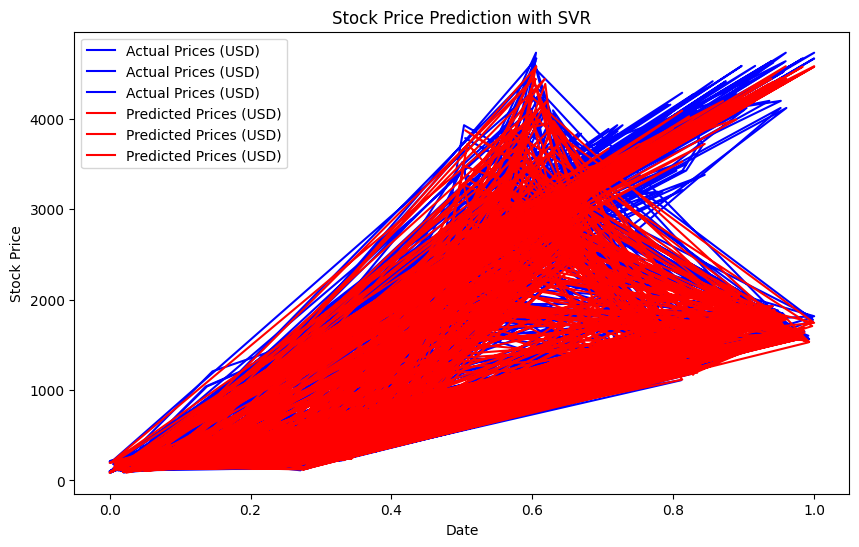

In [447]:
# Plotting performance
plt.figure(figsize = (10, 6))
plt.plot(x_test_scaled, y_test, label = "Actual Prices (USD)", color = "blue")
plt.plot(x_test_scaled, predictions, label = "Predicted Prices (USD)", color = "red")

plt.title("Stock Price Prediction with SVR")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()

plt.show()

Not bad, accuracy is around 98%.
Let's try using an LSTM RNN to see if it can beat the SVR

# Setting up the Data

In [450]:
cleaned_data

,Date,Open,High,Low,Close,Volume,3 Days Future Price
0,17835.0,197.649002,198.337997,196.531006,197.380997,1442380000,200.186005
1,17836.0,197.537003,203.753998,197.328003,198.871994,1336700000,207.485992
2,17837.0,198.981995,201.268997,198.755005,200.634995,1451870000,209.091003
3,17838.0,200.740005,200.740005,199.524994,200.186005,1307150000,218.451996
4,17839.0,200.158005,211.272003,198.985992,207.485992,1749300000,217.182999
...,...,...,...,...,...,...,...
1819,19654.0,1766.014648,1852.684448,1758.690063,1784.437500,15888690475,1780.045288
1820,19655.0,1784.905029,1814.484741,1762.147095,1787.397583,9439066475,1776.618164
1821,19656.0,1787.481934,1865.095215,1764.013062,1804.039307,11196672635,1795.546021
1822,19657.0,1803.794922,1804.135864,1751.440063,1780.045288,7493399771,1810.088623


In [468]:
# Similar preprocessing as before
## scaled_input_data = scaler.fit_transform(input_data)
scaled_data = scaler.fit_transform(cleaned_data)
scaled_data

array([[0.00000000e+00, 2.39894853e-02, 2.35095188e-02, ...,
        2.39166633e-02, 1.62583420e-03, 2.45099668e-02],
       [5.48546352e-04, 2.39657858e-02, 2.46363588e-02, ...,
        2.42320327e-02, 3.55271764e-04, 2.60540294e-02],
       [1.09709270e-03, 2.42715530e-02, 2.41193355e-02, ...,
        2.46049353e-02, 1.73992994e-03, 2.63935146e-02],
       ...,
       [9.98902907e-01, 3.60405703e-01, 3.70290987e-01, ...,
        3.63750288e-01, 1.18899092e-01, 3.61953824e-01],
       [9.99451454e-01, 3.63857608e-01, 3.57607932e-01, ...,
        3.58675174e-01, 7.43756302e-02, 3.65029814e-01],
       [1.00000000e+00, 3.58840313e-01, 3.56873381e-01, ...,
        3.57950283e-01, 3.50939100e-02, 3.66377246e-01]])

In [490]:
# Training set is 80% of the dataset, test set is the remaining 20%
train_data_len = math.floor(0.8 * len(scaled_data))

In [517]:
# Splitting the data into one set (for training and validation) and another set for testing
regular_set = scaled_data[0:train_data_len, :]
test_set = scaled_data[train_data_len:, :]

In [518]:
# How many days in the past to use to predict the next price
TIMESTEP = 15
# The column(s) in the DataFrame that contain the input and output (target) values respectively
INPUT_COLS = [0, 1, 4] # Date, Open, and Close columns
OUTPUT_COLS = 6 # Future Price column

# Creating x and y input datasets
def create_datasets(data, timestep, input_cols, output_cols): # Takes in the training/test set, the number of previous days to refer to, and the columns to extract input/output from
    x, y = [], []
    for i in range(len(data) - timestep):
        x.append(data[i:(i + timestep), input_cols]) # Taking slices of {timestep} many rows, and taking the first, second, and fourth column from each of those rows (Date, Open, and Close columns)
        y.append(data[i + timestep, output_cols]) # The target is the future price after {timestep} many days
    return np.array(x), np.array(y)

In [519]:
# Create x and y datasets
x, y = create_datasets(regular_set, TIMESTEP, INPUT_COLS, OUTPUT_COLS)
x_test, y_test = create_datasets(test_set, TIMESTEP, INPUT_COLS, OUTPUT_COLS)

# Display the shapes of the resulting arrays
print("x shape:", x.shape)
print("y shape:", y.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x shape: (1444, 15, 3)
y shape: (1444,)
x_test shape: (350, 15, 3)
y_test shape: (350,)


In [520]:
# Creating training and validation sets for the neural network
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2)

In [521]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_valid shape:", x_valid.shape)
print("y_valid shape:", y_valid.shape)

x_train shape: (1155, 15, 3)
y_train shape: (1155,)
x_valid shape: (289, 15, 3)
y_valid shape: (289,)


# Building the Neural Network

In [522]:
def optimize_lstm(trial):
    model = Sequential()

    # Initial LSTM layer
    model.add(LSTM(units = trial.suggest_int("first_layer_units", 50, 100), # Testing between 50-100 units
                   return_sequences = True, # 
                   input_shape = (x_train.shape[1], x_train.shape[2]))) # Setting the input shape equal to the number of days to use for prediction (15) and the number of columns being used (3)
    model.add(Dropout(trial.suggest_float("first_layer_dropout", 0.15, 0.25))) # Regularization technique to prevent overfitting; switches some neurons off when the network adjusts its weights, allowing other neurons to learn better
                                                                               # Testing between 15-25% 
    
    model.add(LSTM(units = trial.suggest_int("second_layer_units", 50, 100), # Testing between 50-100 units
                   return_sequences = False))
    model.add(Dropout(trial.suggest_float("second_layer_dropout", 0.15, 0.25))) # Testing between 15-25%

    # 1 unit since we are predicting just one value (future price)
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer = 'Adam', loss = 'mean_squared_error')

    # Getting the model's training stats
    history = model.fit(x_train, y_train, epochs = 15, batch_size = 10, validation_data = (x_valid, y_valid))

    # Using the loss of the last epoch to measure the model's effectiveness
    return history.history['val_loss'][-1]

In [523]:
# Creating the Study object to find the optimal values
study = optuna.create_study(direction = 'minimize')
# Finding optimal hyperparameters
study.optimize(optimize_lstm, n_trials = 100)

# Printing information about the best performing trial
print("Best trial")
trial = study.best_trial

print(f"Value: {trial.value}")
print("Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-11-14 13:18:09,302] A new study created in memory with name: no-name-4bf6a3b4-ad86-4657-9ef6-084a86b5ee49


Epoch 1/15
116/116 [==============================] - 7s 23ms/step - loss: 0.0092 - val_loss: 0.0026
Epoch 2/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 3/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 4/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 7/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 8/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 10/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0024 - val_lo

[I 2023-11-14 13:18:49,071] Trial 0 finished with value: 0.0015692115994170308 and parameters: {'first_layer_units': 68, 'first_layer_dropout': 0.17584928866027727, 'second_layer_units': 92, 'second_layer_dropout': 0.16382093242292742}. Best is trial 0 with value: 0.0015692115994170308.


Epoch 1/15
116/116 [==============================] - 9s 21ms/step - loss: 0.0098 - val_loss: 0.0083
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 3/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 4/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 8/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 9/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 13:19:26,907] Trial 1 finished with value: 0.00159756641369313 and parameters: {'first_layer_units': 72, 'first_layer_dropout': 0.23998551852378083, 'second_layer_units': 96, 'second_layer_dropout': 0.24286847241164275}. Best is trial 0 with value: 0.0015692115994170308.


Epoch 1/15
116/116 [==============================] - 6s 20ms/step - loss: 0.0097 - val_loss: 0.0029
Epoch 2/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 4/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 5/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0036 - val_loss: 0.0044
Epoch 6/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0036 - val_loss: 0.0056
Epoch 7/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 8/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 10/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0028 - val_lo

[I 2023-11-14 13:19:57,148] Trial 2 finished with value: 0.0019846614450216293 and parameters: {'first_layer_units': 66, 'first_layer_dropout': 0.20584896615398354, 'second_layer_units': 83, 'second_layer_dropout': 0.20895279045773438}. Best is trial 0 with value: 0.0015692115994170308.


Epoch 1/15
116/116 [==============================] - 6s 20ms/step - loss: 0.0092 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 3/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 4/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 5/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 6/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 7/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 10/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0029 - val_lo

[I 2023-11-14 13:20:30,127] Trial 3 finished with value: 0.0015960321761667728 and parameters: {'first_layer_units': 72, 'first_layer_dropout': 0.15015720632239066, 'second_layer_units': 80, 'second_layer_dropout': 0.2021390231192247}. Best is trial 0 with value: 0.0015692115994170308.


Epoch 1/15
116/116 [==============================] - 6s 19ms/step - loss: 0.0094 - val_loss: 0.0033
Epoch 2/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 3/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 4/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 5/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 7/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 9/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 10/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0033 - val_lo

[I 2023-11-14 13:21:00,178] Trial 4 finished with value: 0.0016336614498868585 and parameters: {'first_layer_units': 65, 'first_layer_dropout': 0.24577250595393182, 'second_layer_units': 70, 'second_layer_dropout': 0.24622673799348888}. Best is trial 0 with value: 0.0015692115994170308.


Epoch 1/15
116/116 [==============================] - 6s 24ms/step - loss: 0.0110 - val_loss: 0.0028
Epoch 2/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 3/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 4/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 7/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 8/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 9/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0031 - val_lo

[I 2023-11-14 13:21:34,063] Trial 5 finished with value: 0.0016484271036460996 and parameters: {'first_layer_units': 55, 'first_layer_dropout': 0.2415158586847431, 'second_layer_units': 83, 'second_layer_dropout': 0.24854868231199184}. Best is trial 0 with value: 0.0015692115994170308.


Epoch 1/15
116/116 [==============================] - 6s 25ms/step - loss: 0.0094 - val_loss: 0.0023
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 3/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 4/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 7/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 8/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 9/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 10/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0028 - val_lo

[I 2023-11-14 13:22:09,534] Trial 6 finished with value: 0.0015739956870675087 and parameters: {'first_layer_units': 93, 'first_layer_dropout': 0.2109498126425161, 'second_layer_units': 53, 'second_layer_dropout': 0.1522729930543019}. Best is trial 0 with value: 0.0015692115994170308.


Epoch 1/15
116/116 [==============================] - 8s 26ms/step - loss: 0.0077 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 3/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 5/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 6/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 7/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:22:47,836] Trial 7 finished with value: 0.00156206835526973 and parameters: {'first_layer_units': 87, 'first_layer_dropout': 0.1552386223249686, 'second_layer_units': 69, 'second_layer_dropout': 0.18021001012105686}. Best is trial 7 with value: 0.00156206835526973.


Epoch 1/15
116/116 [==============================] - 6s 22ms/step - loss: 0.0072 - val_loss: 0.0050
Epoch 2/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 5/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 7/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0028 - val_lo

[I 2023-11-14 13:23:21,547] Trial 8 finished with value: 0.0017854769248515368 and parameters: {'first_layer_units': 82, 'first_layer_dropout': 0.20628307670039897, 'second_layer_units': 83, 'second_layer_dropout': 0.22431430806783836}. Best is trial 7 with value: 0.00156206835526973.


Epoch 1/15
116/116 [==============================] - 5s 18ms/step - loss: 0.0114 - val_loss: 0.0040
Epoch 2/15
116/116 [==============================] - 1s 13ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 3/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 4/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 5/15
116/116 [==============================] - 2s 13ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 6/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 7/15
116/116 [==============================] - 2s 13ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 8/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 9/15
116/116 [==============================] - 2s 13ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 10/15
116/116 [==============================] - 2s 13ms/step - loss: 0.0031 - val_lo

[I 2023-11-14 13:23:48,781] Trial 9 finished with value: 0.0016103609232231975 and parameters: {'first_layer_units': 65, 'first_layer_dropout': 0.16695479653329992, 'second_layer_units': 54, 'second_layer_dropout': 0.1943136852368199}. Best is trial 7 with value: 0.00156206835526973.


Epoch 1/15
116/116 [==============================] - 6s 25ms/step - loss: 0.0091 - val_loss: 0.0027
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 4/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 6/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 7/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 9/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 10/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0028 - val_lo

[I 2023-11-14 13:24:25,270] Trial 10 finished with value: 0.002624809741973877 and parameters: {'first_layer_units': 99, 'first_layer_dropout': 0.18300657753889465, 'second_layer_units': 64, 'second_layer_dropout': 0.17717617491817045}. Best is trial 7 with value: 0.00156206835526973.


Epoch 1/15
116/116 [==============================] - 5s 23ms/step - loss: 0.0099 - val_loss: 0.0021
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 3/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 7/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 9/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:25:02,249] Trial 11 finished with value: 0.0018512721871957183 and parameters: {'first_layer_units': 84, 'first_layer_dropout': 0.15252983079611124, 'second_layer_units': 100, 'second_layer_dropout': 0.1679032216186067}. Best is trial 7 with value: 0.00156206835526973.


Epoch 1/15
116/116 [==============================] - 5s 20ms/step - loss: 0.0084 - val_loss: 0.0027
Epoch 2/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 3/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 5/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 6/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 7/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 9/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 13:25:33,552] Trial 12 finished with value: 0.0018048197962343693 and parameters: {'first_layer_units': 85, 'first_layer_dropout': 0.17515455587945333, 'second_layer_units': 68, 'second_layer_dropout': 0.17683105226730894}. Best is trial 7 with value: 0.00156206835526973.


Epoch 1/15
116/116 [==============================] - 5s 20ms/step - loss: 0.0082 - val_loss: 0.0037
Epoch 2/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 3/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 8/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 9/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 10/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:26:03,673] Trial 13 finished with value: 0.0016250157495960593 and parameters: {'first_layer_units': 57, 'first_layer_dropout': 0.16661952799178611, 'second_layer_units': 93, 'second_layer_dropout': 0.1518971401525327}. Best is trial 7 with value: 0.00156206835526973.


Epoch 1/15
116/116 [==============================] - 5s 19ms/step - loss: 0.0079 - val_loss: 0.0024
Epoch 2/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 3/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 5/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 7/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 8/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 9/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:26:36,598] Trial 14 finished with value: 0.001602699514478445 and parameters: {'first_layer_units': 78, 'first_layer_dropout': 0.18716993014919253, 'second_layer_units': 60, 'second_layer_dropout': 0.1677216859632975}. Best is trial 7 with value: 0.00156206835526973.


Epoch 1/15
116/116 [==============================] - 7s 30ms/step - loss: 0.0084 - val_loss: 0.0025
Epoch 2/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 3/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 4/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 5/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 7/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 13:27:16,936] Trial 15 finished with value: 0.00213768077082932 and parameters: {'first_layer_units': 91, 'first_layer_dropout': 0.1613828846507621, 'second_layer_units': 75, 'second_layer_dropout': 0.18879550043728796}. Best is trial 7 with value: 0.00156206835526973.


Epoch 1/15
116/116 [==============================] - 7s 22ms/step - loss: 0.0098 - val_loss: 0.0056
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 3/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 4/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 5/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 3s 26ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 8/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0030 - val_lo

[I 2023-11-14 13:27:54,177] Trial 16 finished with value: 0.0018818246899172664 and parameters: {'first_layer_units': 51, 'first_layer_dropout': 0.1885233858892933, 'second_layer_units': 89, 'second_layer_dropout': 0.18473225479058572}. Best is trial 7 with value: 0.00156206835526973.


Epoch 1/15
116/116 [==============================] - 9s 31ms/step - loss: 0.0089 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 3/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 4/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 5/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 7/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 9/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 13:28:34,560] Trial 17 finished with value: 0.002259455854073167 and parameters: {'first_layer_units': 77, 'first_layer_dropout': 0.15866895773577083, 'second_layer_units': 74, 'second_layer_dropout': 0.1630151557472274}. Best is trial 7 with value: 0.00156206835526973.


Epoch 1/15
116/116 [==============================] - 6s 21ms/step - loss: 0.0090 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0043 - val_loss: 0.0026
Epoch 3/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 4/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 8/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 10/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0031 - val_lo

[I 2023-11-14 13:29:12,928] Trial 18 finished with value: 0.002054876182228327 and parameters: {'first_layer_units': 89, 'first_layer_dropout': 0.17154231049944477, 'second_layer_units': 60, 'second_layer_dropout': 0.17857175063333305}. Best is trial 7 with value: 0.00156206835526973.


Epoch 1/15
116/116 [==============================] - 9s 30ms/step - loss: 0.0082 - val_loss: 0.0023
Epoch 2/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 3/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 5/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 7/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 9/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 10/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 13:29:57,571] Trial 19 finished with value: 0.0015651305438950658 and parameters: {'first_layer_units': 100, 'first_layer_dropout': 0.15083235944892204, 'second_layer_units': 88, 'second_layer_dropout': 0.16023501324075348}. Best is trial 7 with value: 0.00156206835526973.


Epoch 1/15
116/116 [==============================] - 8s 28ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 2/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 4/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 5/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 7/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 9/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 10/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0024 - val_lo

[I 2023-11-14 13:30:41,802] Trial 20 finished with value: 0.001627488061785698 and parameters: {'first_layer_units': 100, 'first_layer_dropout': 0.15754330148160708, 'second_layer_units': 88, 'second_layer_dropout': 0.1502605161089176}. Best is trial 7 with value: 0.00156206835526973.


Epoch 1/15
116/116 [==============================] - 7s 26ms/step - loss: 0.0067 - val_loss: 0.0041
Epoch 2/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 3/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 4/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 5/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 6/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 9/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 3s 28ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:31:27,560] Trial 21 finished with value: 0.0015606960514560342 and parameters: {'first_layer_units': 96, 'first_layer_dropout': 0.15050459159554683, 'second_layer_units': 90, 'second_layer_dropout': 0.1627927647913644}. Best is trial 21 with value: 0.0015606960514560342.


Epoch 1/15
116/116 [==============================] - 13s 45ms/step - loss: 0.0067 - val_loss: 0.0025
Epoch 2/15
116/116 [==============================] - 4s 31ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 3s 27ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 4/15
116/116 [==============================] - 3s 26ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 5/15
116/116 [==============================] - 3s 29ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 6/15
116/116 [==============================] - 3s 25ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 7/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 8/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 9/15
116/116 [==============================] - 4s 37ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0023 - val_l

[I 2023-11-14 13:32:20,005] Trial 22 finished with value: 0.001551824389025569 and parameters: {'first_layer_units': 95, 'first_layer_dropout': 0.15019873920858698, 'second_layer_units': 77, 'second_layer_dropout': 0.15954412205465648}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 8s 25ms/step - loss: 0.0101 - val_loss: 0.0026
Epoch 2/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 3/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 7/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0028 - val_lo

[I 2023-11-14 13:33:03,525] Trial 23 finished with value: 0.0019079326884821057 and parameters: {'first_layer_units': 94, 'first_layer_dropout': 0.1621321265673563, 'second_layer_units': 78, 'second_layer_dropout': 0.17118689826885033}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 6s 24ms/step - loss: 0.0078 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 5/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 6/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 8/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0025 - val_lo

[I 2023-11-14 13:33:39,172] Trial 24 finished with value: 0.0018715487094596028 and parameters: {'first_layer_units': 95, 'first_layer_dropout': 0.15619763843082418, 'second_layer_units': 72, 'second_layer_dropout': 0.15649513159298867}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 6s 24ms/step - loss: 0.0096 - val_loss: 0.0021
Epoch 2/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0037 - val_loss: 0.0053
Epoch 3/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 4/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 6/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 7/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 8/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 9/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 13:34:09,814] Trial 25 finished with value: 0.0020764737855643034 and parameters: {'first_layer_units': 88, 'first_layer_dropout': 0.15135773309723213, 'second_layer_units': 66, 'second_layer_dropout': 0.15946994755084032}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 6s 22ms/step - loss: 0.0096 - val_loss: 0.0058
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 3/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 4/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 6/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 8/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 9/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0028 - val_lo

[I 2023-11-14 13:34:43,617] Trial 26 finished with value: 0.002579025225713849 and parameters: {'first_layer_units': 96, 'first_layer_dropout': 0.16472705937474144, 'second_layer_units': 79, 'second_layer_dropout': 0.17140674057445246}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 6s 23ms/step - loss: 0.0109 - val_loss: 0.0025
Epoch 2/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 3/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 5/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0034 - val_loss: 0.0044
Epoch 6/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 8/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 9/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0028 - val_lo

[I 2023-11-14 13:35:13,572] Trial 27 finished with value: 0.0015717491041868925 and parameters: {'first_layer_units': 88, 'first_layer_dropout': 0.15900482372862887, 'second_layer_units': 61, 'second_layer_dropout': 0.18280965813177413}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 6s 21ms/step - loss: 0.0087 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 5/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 6/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 9/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0025 - val_lo

[I 2023-11-14 13:35:47,855] Trial 28 finished with value: 0.0016743139130994678 and parameters: {'first_layer_units': 81, 'first_layer_dropout': 0.17040367136076173, 'second_layer_units': 100, 'second_layer_dropout': 0.17261568938347044}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 5s 22ms/step - loss: 0.0092 - val_loss: 0.0024
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 3/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 4/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 5/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 8/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 9/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0029 - val_lo

[I 2023-11-14 13:36:22,302] Trial 29 finished with value: 0.00155791942961514 and parameters: {'first_layer_units': 97, 'first_layer_dropout': 0.17781611850051343, 'second_layer_units': 71, 'second_layer_dropout': 0.16420304152476325}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 7s 31ms/step - loss: 0.0100 - val_loss: 0.0021
Epoch 2/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 3/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 5/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 7/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 8/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 9/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 10/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0024 - val_lo

[I 2023-11-14 13:37:01,909] Trial 30 finished with value: 0.0016220815014094114 and parameters: {'first_layer_units': 97, 'first_layer_dropout': 0.17628262329027963, 'second_layer_units': 95, 'second_layer_dropout': 0.16531452564472662}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 5s 22ms/step - loss: 0.0102 - val_loss: 0.0026
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 4/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 8/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0025 - val_lo

[I 2023-11-14 13:37:37,623] Trial 31 finished with value: 0.0031603549141436815 and parameters: {'first_layer_units': 91, 'first_layer_dropout': 0.15004082787300496, 'second_layer_units': 71, 'second_layer_dropout': 0.15971921256217564}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 6s 25ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 2/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 3/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 4/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 5/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 8/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 10/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0025 - val_lo

[I 2023-11-14 13:38:11,236] Trial 32 finished with value: 0.0017697761068120599 and parameters: {'first_layer_units': 92, 'first_layer_dropout': 0.15859231980683847, 'second_layer_units': 65, 'second_layer_dropout': 0.1646888628308024}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 5s 23ms/step - loss: 0.0078 - val_loss: 0.0023
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 4/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 5/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 7/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 8/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 9/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 10/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0023 - val_lo

[I 2023-11-14 13:38:46,075] Trial 33 finished with value: 0.001604962395504117 and parameters: {'first_layer_units': 96, 'first_layer_dropout': 0.16433136496151884, 'second_layer_units': 77, 'second_layer_dropout': 0.15544896475480385}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 5s 21ms/step - loss: 0.0085 - val_loss: 0.0026
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 3/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0038 - val_loss: 0.0059
Epoch 4/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 5/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0028 - val_lo

[I 2023-11-14 13:39:20,128] Trial 34 finished with value: 0.0015563499182462692 and parameters: {'first_layer_units': 85, 'first_layer_dropout': 0.15429771685243066, 'second_layer_units': 85, 'second_layer_dropout': 0.1635142914975254}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 6s 21ms/step - loss: 0.0099 - val_loss: 0.0023
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 4/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 7/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 8/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 9/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 13:39:52,021] Trial 35 finished with value: 0.0019851147662848234 and parameters: {'first_layer_units': 72, 'first_layer_dropout': 0.15587308241489375, 'second_layer_units': 85, 'second_layer_dropout': 0.15703905935090234}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 6s 22ms/step - loss: 0.0094 - val_loss: 0.0024
Epoch 2/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 3/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 5/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 6/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 9/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0028 - val_lo

[I 2023-11-14 13:40:26,888] Trial 36 finished with value: 0.0016516714822500944 and parameters: {'first_layer_units': 98, 'first_layer_dropout': 0.16823934162397106, 'second_layer_units': 81, 'second_layer_dropout': 0.16268772546871846}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 5s 21ms/step - loss: 0.0083 - val_loss: 0.0029
Epoch 2/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 3/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 4/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 6/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 7/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 8/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 9/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 10/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0024 - val_lo

[I 2023-11-14 13:40:59,785] Trial 37 finished with value: 0.001705534989014268 and parameters: {'first_layer_units': 91, 'first_layer_dropout': 0.1630171370758331, 'second_layer_units': 86, 'second_layer_dropout': 0.1730856796752843}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 5s 21ms/step - loss: 0.0099 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 4/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 5/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 7/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 9/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 10/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0025 - val_lo

[I 2023-11-14 13:41:31,745] Trial 38 finished with value: 0.0017156470566987991 and parameters: {'first_layer_units': 85, 'first_layer_dropout': 0.15001950779941875, 'second_layer_units': 92, 'second_layer_dropout': 0.15424521209625752}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 6s 30ms/step - loss: 0.0079 - val_loss: 0.0039
Epoch 2/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 3/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 4/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 7/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 9/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0025 - val_lo

[I 2023-11-14 13:42:04,806] Trial 39 finished with value: 0.0019296968821436167 and parameters: {'first_layer_units': 81, 'first_layer_dropout': 0.17434966022135784, 'second_layer_units': 81, 'second_layer_dropout': 0.16815013809321322}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 6s 23ms/step - loss: 0.0093 - val_loss: 0.0079
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0038 - val_loss: 0.0058
Epoch 3/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 4/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 7/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 8/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 9/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0025 - val_lo

[I 2023-11-14 13:42:44,013] Trial 40 finished with value: 0.0024821944534778595 and parameters: {'first_layer_units': 93, 'first_layer_dropout': 0.15548512586596847, 'second_layer_units': 91, 'second_layer_dropout': 0.15102146007733355}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 6s 23ms/step - loss: 0.0115 - val_loss: 0.0024
Epoch 2/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 3/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 4/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 5/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 6/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 7/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 9/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:43:20,564] Trial 41 finished with value: 0.0028794435784220695 and parameters: {'first_layer_units': 87, 'first_layer_dropout': 0.15495617152919203, 'second_layer_units': 69, 'second_layer_dropout': 0.16216251335909637}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 6s 23ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 4/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 5/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 7/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 8/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 9/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 10/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:43:56,905] Trial 42 finished with value: 0.0018991809338331223 and parameters: {'first_layer_units': 95, 'first_layer_dropout': 0.16131403845397452, 'second_layer_units': 73, 'second_layer_dropout': 0.17584026010943019}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 5s 20ms/step - loss: 0.0086 - val_loss: 0.0021
Epoch 2/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 4/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 6/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 7/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0029 - val_loss: 0.0048
Epoch 8/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 9/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0028 - val_lo

[I 2023-11-14 13:44:30,411] Trial 43 finished with value: 0.0016083564842119813 and parameters: {'first_layer_units': 90, 'first_layer_dropout': 0.154886523787903, 'second_layer_units': 77, 'second_layer_dropout': 0.1665318767382189}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 5s 21ms/step - loss: 0.0072 - val_loss: 0.0032
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 3/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 4/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 6/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0030 - val_lo

[I 2023-11-14 13:45:06,129] Trial 44 finished with value: 0.0020058227237313986 and parameters: {'first_layer_units': 83, 'first_layer_dropout': 0.16778258348115438, 'second_layer_units': 84, 'second_layer_dropout': 0.18127845784599084}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 5s 21ms/step - loss: 0.0083 - val_loss: 0.0023
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 4/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 5/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 6/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 7/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 9/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0024 - val_lo

[I 2023-11-14 13:45:39,130] Trial 45 finished with value: 0.002235810039564967 and parameters: {'first_layer_units': 86, 'first_layer_dropout': 0.1623576172699436, 'second_layer_units': 67, 'second_layer_dropout': 0.15795339590226257}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 5s 19ms/step - loss: 0.0094 - val_loss: 0.0030
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 4/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 6/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 7/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 9/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 10/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:46:10,024] Trial 46 finished with value: 0.00194024876691401 and parameters: {'first_layer_units': 78, 'first_layer_dropout': 0.180178429562635, 'second_layer_units': 71, 'second_layer_dropout': 0.16944266091496998}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 5s 20ms/step - loss: 0.0090 - val_loss: 0.0027
Epoch 2/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 3/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 5/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 6/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 7/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0028 - val_lo

[I 2023-11-14 13:46:43,528] Trial 47 finished with value: 0.0017439316725358367 and parameters: {'first_layer_units': 93, 'first_layer_dropout': 0.15413527399557284, 'second_layer_units': 50, 'second_layer_dropout': 0.188767822073394}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 6s 25ms/step - loss: 0.0080 - val_loss: 0.0021
Epoch 2/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 3/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 5/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 7/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:47:23,822] Trial 48 finished with value: 0.0018961194436997175 and parameters: {'first_layer_units': 98, 'first_layer_dropout': 0.17022679589974557, 'second_layer_units': 97, 'second_layer_dropout': 0.17574980263678058}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 5s 20ms/step - loss: 0.0099 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 3/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0031 - val_loss: 0.0058
Epoch 7/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0029 - val_lo

[I 2023-11-14 13:47:53,732] Trial 49 finished with value: 0.0023487776052206755 and parameters: {'first_layer_units': 70, 'first_layer_dropout': 0.15953519041847286, 'second_layer_units': 75, 'second_layer_dropout': 0.16469692075121461}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 7s 21ms/step - loss: 0.0076 - val_loss: 0.0031
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 3/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 4/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 7/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0024 - val_lo

[I 2023-11-14 13:48:27,617] Trial 50 finished with value: 0.002062548417598009 and parameters: {'first_layer_units': 74, 'first_layer_dropout': 0.15020760966341282, 'second_layer_units': 82, 'second_layer_dropout': 0.15436706372445003}. Best is trial 22 with value: 0.001551824389025569.


Epoch 1/15
116/116 [==============================] - 5s 23ms/step - loss: 0.0057 - val_loss: 0.0021
Epoch 2/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 3/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 4/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 5/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 7/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 9/15
116/116 [==============================] - 2s 22ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0025 - val_lo

[I 2023-11-14 13:49:07,613] Trial 51 finished with value: 0.001518589211627841 and parameters: {'first_layer_units': 100, 'first_layer_dropout': 0.1525669159514888, 'second_layer_units': 87, 'second_layer_dropout': 0.16014331683930952}. Best is trial 51 with value: 0.001518589211627841.


Epoch 1/15
116/116 [==============================] - 6s 25ms/step - loss: 0.0071 - val_loss: 0.0036
Epoch 2/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 4/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 10/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0024 - val_lo

[I 2023-11-14 13:49:48,392] Trial 52 finished with value: 0.0014909786405041814 and parameters: {'first_layer_units': 100, 'first_layer_dropout': 0.15394911251973542, 'second_layer_units': 87, 'second_layer_dropout': 0.15934017681475063}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 5s 23ms/step - loss: 0.0103 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 3/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 2s 22ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0031 - val_loss: 0.0051
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 7/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 10/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0025 - val_lo

[I 2023-11-14 13:50:28,269] Trial 53 finished with value: 0.0016326562035828829 and parameters: {'first_layer_units': 100, 'first_layer_dropout': 0.16584246612974773, 'second_layer_units': 90, 'second_layer_dropout': 0.16103397435390274}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 26ms/step - loss: 0.0099 - val_loss: 0.0024
Epoch 2/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 3/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 4/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 5/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 7/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 10/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0023 - val_lo

[I 2023-11-14 13:51:07,971] Trial 54 finished with value: 0.0015249238349497318 and parameters: {'first_layer_units': 98, 'first_layer_dropout': 0.15342590937328346, 'second_layer_units': 87, 'second_layer_dropout': 0.15393815110582879}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 5s 19ms/step - loss: 0.0061 - val_loss: 0.0025
Epoch 2/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 5/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 6/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 8/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 9/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 10/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:51:39,239] Trial 55 finished with value: 0.0015278098871931434 and parameters: {'first_layer_units': 62, 'first_layer_dropout': 0.1579756772790421, 'second_layer_units': 86, 'second_layer_dropout': 0.15007850850466103}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 5s 20ms/step - loss: 0.0081 - val_loss: 0.0024
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 3/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 4/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 6/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 8/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 9/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:52:09,987] Trial 56 finished with value: 0.0022087597753852606 and parameters: {'first_layer_units': 58, 'first_layer_dropout': 0.15402570482402458, 'second_layer_units': 87, 'second_layer_dropout': 0.1502473709302064}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 5s 19ms/step - loss: 0.0073 - val_loss: 0.0024
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 3/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 5/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 6/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 9/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0030 - val_lo

[I 2023-11-14 13:52:39,590] Trial 57 finished with value: 0.0017311610281467438 and parameters: {'first_layer_units': 68, 'first_layer_dropout': 0.15934505537268684, 'second_layer_units': 94, 'second_layer_dropout': 0.15438801090696336}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 5s 19ms/step - loss: 0.0100 - val_loss: 0.0024
Epoch 2/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 3/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 5/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 6/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 8/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0030 - val_lo

[I 2023-11-14 13:53:09,457] Trial 58 finished with value: 0.0019252521451562643 and parameters: {'first_layer_units': 61, 'first_layer_dropout': 0.15802798331888074, 'second_layer_units': 84, 'second_layer_dropout': 0.15763404302451894}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 5s 19ms/step - loss: 0.0094 - val_loss: 0.0023
Epoch 2/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 5/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 7/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 8/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 9/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 10/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 13:53:37,800] Trial 59 finished with value: 0.001570728374645114 and parameters: {'first_layer_units': 62, 'first_layer_dropout': 0.1644199949730167, 'second_layer_units': 86, 'second_layer_dropout': 0.15341665531924184}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 5s 19ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 4/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 5/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 6/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 7/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 9/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 10/15
116/116 [==============================] - 2s 14ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:54:06,015] Trial 60 finished with value: 0.001938337692990899 and parameters: {'first_layer_units': 50, 'first_layer_dropout': 0.15397776544492248, 'second_layer_units': 89, 'second_layer_dropout': 0.15041587236479242}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 5s 22ms/step - loss: 0.0062 - val_loss: 0.0024
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 4/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 5/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 6/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 8/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 10/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0022 - val_lo

[I 2023-11-14 13:54:42,266] Trial 61 finished with value: 0.001954508014023304 and parameters: {'first_layer_units': 98, 'first_layer_dropout': 0.1609607534691049, 'second_layer_units': 83, 'second_layer_dropout': 0.15916562139368168}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 7s 36ms/step - loss: 0.0116 - val_loss: 0.0025
Epoch 2/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 3/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 4/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 5/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 6/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 8/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 9/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 10/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:55:21,624] Trial 62 finished with value: 0.0019561455119401217 and parameters: {'first_layer_units': 99, 'first_layer_dropout': 0.15324058528190707, 'second_layer_units': 97, 'second_layer_dropout': 0.16729678262873626}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 5s 23ms/step - loss: 0.0079 - val_loss: 0.0033
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 3/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 4/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 7/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 22ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 10/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:55:59,377] Trial 63 finished with value: 0.002078140387311578 and parameters: {'first_layer_units': 100, 'first_layer_dropout': 0.15780843325558092, 'second_layer_units': 80, 'second_layer_dropout': 0.15722493936438015}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 5s 23ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 3/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 4/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 5/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 6/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 7/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 10/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:56:37,568] Trial 64 finished with value: 0.0015674715396016836 and parameters: {'first_layer_units': 94, 'first_layer_dropout': 0.15232309629477556, 'second_layer_units': 88, 'second_layer_dropout': 0.16150401076543383}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 5s 20ms/step - loss: 0.0085 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 3/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 6/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 7/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 9/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0023 - val_lo

[I 2023-11-14 13:57:09,546] Trial 65 finished with value: 0.0017488475423306227 and parameters: {'first_layer_units': 53, 'first_layer_dropout': 0.16527141968949371, 'second_layer_units': 86, 'second_layer_dropout': 0.1535400401314734}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 26ms/step - loss: 0.0072 - val_loss: 0.0021
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 3/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 7/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:57:45,710] Trial 66 finished with value: 0.002114959293976426 and parameters: {'first_layer_units': 97, 'first_layer_dropout': 0.16084899333628558, 'second_layer_units': 92, 'second_layer_dropout': 0.1646570799696084}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 5s 22ms/step - loss: 0.0095 - val_loss: 0.0046
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 4/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 5/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 6/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 8/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 9/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 13:58:20,889] Trial 67 finished with value: 0.0018988588126376271 and parameters: {'first_layer_units': 95, 'first_layer_dropout': 0.1573555817042214, 'second_layer_units': 77, 'second_layer_dropout': 0.15974868828004227}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 5s 21ms/step - loss: 0.0094 - val_loss: 0.0021
Epoch 2/15
116/116 [==============================] - 2s 15ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 4/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 6/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 7/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 8/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 9/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 13:58:57,198] Trial 68 finished with value: 0.001937253400683403 and parameters: {'first_layer_units': 97, 'first_layer_dropout': 0.15649076653136593, 'second_layer_units': 63, 'second_layer_dropout': 0.170571300999584}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 24ms/step - loss: 0.0069 - val_loss: 0.0030
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 3/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 5/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 8/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 9/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0028 - val_lo

[I 2023-11-14 13:59:32,252] Trial 69 finished with value: 0.0015048962086439133 and parameters: {'first_layer_units': 98, 'first_layer_dropout': 0.15234228774689806, 'second_layer_units': 79, 'second_layer_dropout': 0.15701825679583756}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 24ms/step - loss: 0.0070 - val_loss: 0.0023
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 5/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 7/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 14:00:08,744] Trial 70 finished with value: 0.0015941803576424718 and parameters: {'first_layer_units': 99, 'first_layer_dropout': 0.1500354794177767, 'second_layer_units': 79, 'second_layer_dropout': 0.15591849031008698}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 25ms/step - loss: 0.0060 - val_loss: 0.0033
Epoch 2/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 4/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 5/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 7/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 9/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 10/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0023 - val_lo

[I 2023-11-14 14:00:49,468] Trial 71 finished with value: 0.0015790535835549235 and parameters: {'first_layer_units': 94, 'first_layer_dropout': 0.15277537535789196, 'second_layer_units': 82, 'second_layer_dropout': 0.16281051343689967}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 24ms/step - loss: 0.0078 - val_loss: 0.0023
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0045 - val_loss: 0.0063
Epoch 3/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 6/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0024 - val_lo

[I 2023-11-14 14:01:26,567] Trial 72 finished with value: 0.002994643058627844 and parameters: {'first_layer_units': 98, 'first_layer_dropout': 0.162492267090519, 'second_layer_units': 84, 'second_layer_dropout': 0.15315287639617656}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 23ms/step - loss: 0.0093 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 4/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 5/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 6/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 8/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 9/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0031 - val_lo

[I 2023-11-14 14:02:03,396] Trial 73 finished with value: 0.0015899264253675938 and parameters: {'first_layer_units': 96, 'first_layer_dropout': 0.152880280444144, 'second_layer_units': 74, 'second_layer_dropout': 0.1590467444812271}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 24ms/step - loss: 0.0088 - val_loss: 0.0023
Epoch 2/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 4/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 5/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 7/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 9/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 10/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_lo

[I 2023-11-14 14:02:43,234] Trial 74 finished with value: 0.001642088987864554 and parameters: {'first_layer_units': 100, 'first_layer_dropout': 0.1562365432878666, 'second_layer_units': 87, 'second_layer_dropout': 0.1672453080027534}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 5s 22ms/step - loss: 0.0079 - val_loss: 0.0030
Epoch 2/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0042 - val_loss: 0.0058
Epoch 3/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 4/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 5/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 6/15
116/116 [==============================] - 2s 16ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 7/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 9/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 10/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 14:03:17,222] Trial 75 finished with value: 0.0016779248835518956 and parameters: {'first_layer_units': 92, 'first_layer_dropout': 0.15976672731380376, 'second_layer_units': 76, 'second_layer_dropout': 0.15619895391393304}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 22ms/step - loss: 0.0099 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 3/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 4/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 6/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 7/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 2s 17ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 14:03:53,343] Trial 76 finished with value: 0.0017484768759459257 and parameters: {'first_layer_units': 89, 'first_layer_dropout': 0.16737713690158207, 'second_layer_units': 79, 'second_layer_dropout': 0.16418462770466627}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 18s 25ms/step - loss: 0.0075 - val_loss: 0.0021
Epoch 2/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 4/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 6/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0025 - val_l

[I 2023-11-14 14:04:46,155] Trial 77 finished with value: 0.001540149562060833 and parameters: {'first_layer_units': 97, 'first_layer_dropout': 0.16359321102955082, 'second_layer_units': 89, 'second_layer_dropout': 0.15237255029674723}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 26ms/step - loss: 0.0091 - val_loss: 0.0024
Epoch 2/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 7/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 8/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 10/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 14:05:25,873] Trial 78 finished with value: 0.001868825638666749 and parameters: {'first_layer_units': 95, 'first_layer_dropout': 0.15243971722076394, 'second_layer_units': 89, 'second_layer_dropout': 0.15231081600677707}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 27ms/step - loss: 0.0067 - val_loss: 0.0021
Epoch 2/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0035 - val_loss: 0.0050
Epoch 3/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 5/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 6/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 10/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0024 - val_lo

[I 2023-11-14 14:06:05,173] Trial 79 finished with value: 0.0014912470942363143 and parameters: {'first_layer_units': 99, 'first_layer_dropout': 0.1567145409215104, 'second_layer_units': 91, 'second_layer_dropout': 0.15189412466409505}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 25ms/step - loss: 0.0084 - val_loss: 0.0023
Epoch 2/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 4/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 5/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 8/15
116/116 [==============================] - 3s 25ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0025 - val_lo

[I 2023-11-14 14:06:45,388] Trial 80 finished with value: 0.001612239284440875 and parameters: {'first_layer_units': 99, 'first_layer_dropout': 0.1627229930681203, 'second_layer_units': 93, 'second_layer_dropout': 0.15057664182903216}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 25ms/step - loss: 0.0073 - val_loss: 0.0023
Epoch 2/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 3/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 4/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 5/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 6/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 7/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 9/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 10/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0028 - val_lo

[I 2023-11-14 14:07:24,853] Trial 81 finished with value: 0.001502449857071042 and parameters: {'first_layer_units': 97, 'first_layer_dropout': 0.15683389603323783, 'second_layer_units': 91, 'second_layer_dropout': 0.15606854934994033}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 7s 32ms/step - loss: 0.0073 - val_loss: 0.0052
Epoch 2/15
116/116 [==============================] - 3s 26ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 3/15
116/116 [==============================] - 3s 25ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 6/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 7/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 10/15
116/116 [==============================] - 3s 26ms/step - loss: 0.0029 - val_lo

[I 2023-11-14 14:08:08,771] Trial 82 finished with value: 0.0016082458896562457 and parameters: {'first_layer_units': 97, 'first_layer_dropout': 0.157501890873169, 'second_layer_units': 91, 'second_layer_dropout': 0.15649565445822006}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 9s 29ms/step - loss: 0.0099 - val_loss: 0.0060
Epoch 2/15
116/116 [==============================] - 3s 25ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 3s 26ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 5/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 6/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 7/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 8/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0024 - val_lo

[I 2023-11-14 14:08:54,994] Trial 83 finished with value: 0.001863409299403429 and parameters: {'first_layer_units': 100, 'first_layer_dropout': 0.15683868092975403, 'second_layer_units': 90, 'second_layer_dropout': 0.15306510452040173}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 25ms/step - loss: 0.0066 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 3/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 4/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 7/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 9/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 10/15
116/116 [==============================] - 2s 22ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 14:09:35,032] Trial 84 finished with value: 0.0016037501627579331 and parameters: {'first_layer_units': 96, 'first_layer_dropout': 0.15966632647771944, 'second_layer_units': 95, 'second_layer_dropout': 0.16004051029152638}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 24ms/step - loss: 0.0062 - val_loss: 0.0024
Epoch 2/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 3/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 4/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 5/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 7/15
116/116 [==============================] - 2s 18ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 8/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 10/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 14:10:17,261] Trial 85 finished with value: 0.0024097647983580828 and parameters: {'first_layer_units': 94, 'first_layer_dropout': 0.1512834659137354, 'second_layer_units': 91, 'second_layer_dropout': 0.15521773801993408}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 7s 29ms/step - loss: 0.0073 - val_loss: 0.0023
Epoch 2/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 3/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 4/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 5/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 6/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 8/15
116/116 [==============================] - 3s 25ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 3s 30ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 10/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0025 - val_lo

[I 2023-11-14 14:11:04,003] Trial 86 finished with value: 0.003926437348127365 and parameters: {'first_layer_units': 98, 'first_layer_dropout': 0.15504139591383728, 'second_layer_units': 88, 'second_layer_dropout': 0.15222829170762806}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 8s 27ms/step - loss: 0.0103 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 3s 25ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 3/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 5/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 6/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 7/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 8/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0029 - val_loss: 0.0062
Epoch 9/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 10/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 14:11:47,484] Trial 87 finished with value: 0.001541120931506157 and parameters: {'first_layer_units': 93, 'first_layer_dropout': 0.1630955182151925, 'second_layer_units': 93, 'second_layer_dropout': 0.1500600149005729}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 25ms/step - loss: 0.0087 - val_loss: 0.0024
Epoch 2/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 3s 25ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 5/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 7/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 9/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 10/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0025 - val_lo

[I 2023-11-14 14:12:31,626] Trial 88 finished with value: 0.0016302444273605943 and parameters: {'first_layer_units': 99, 'first_layer_dropout': 0.17039466204077314, 'second_layer_units': 98, 'second_layer_dropout': 0.15014160571614085}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 8s 31ms/step - loss: 0.0073 - val_loss: 0.0029
Epoch 2/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 4/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 5/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 7/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 8/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 10/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0025 - val_lo

[I 2023-11-14 14:13:15,906] Trial 89 finished with value: 0.0015590303810313344 and parameters: {'first_layer_units': 93, 'first_layer_dropout': 0.16334563838290553, 'second_layer_units': 93, 'second_layer_dropout': 0.15752022377339475}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 8s 28ms/step - loss: 0.0061 - val_loss: 0.0021
Epoch 2/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 5/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 9/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 10/15
116/116 [==============================] - 3s 29ms/step - loss: 0.0024 - val_lo

[I 2023-11-14 14:14:02,050] Trial 90 finished with value: 0.0015135309658944607 and parameters: {'first_layer_units': 92, 'first_layer_dropout': 0.17223681767216004, 'second_layer_units': 95, 'second_layer_dropout': 0.15488266023297823}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 7s 31ms/step - loss: 0.0082 - val_loss: 0.0036
Epoch 2/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 3/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0037 - val_loss: 0.0047
Epoch 4/15
116/116 [==============================] - 2s 19ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 5/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 9/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 10/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 14:14:44,880] Trial 91 finished with value: 0.0018488871864974499 and parameters: {'first_layer_units': 92, 'first_layer_dropout': 0.16582012588808656, 'second_layer_units': 95, 'second_layer_dropout': 0.15512263233815976}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 8s 30ms/step - loss: 0.0073 - val_loss: 0.0036
Epoch 2/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 3/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 4/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 5/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 6/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 7/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0021 - val_lo

[I 2023-11-14 14:15:27,960] Trial 92 finished with value: 0.0015157441375777125 and parameters: {'first_layer_units': 96, 'first_layer_dropout': 0.1604314898490348, 'second_layer_units': 94, 'second_layer_dropout': 0.1532641724500172}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 7s 32ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 4/15
116/116 [==============================] - 3s 25ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 8/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 9/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 2s 22ms/step - loss: 0.0023 - val_lo

[I 2023-11-14 14:16:13,313] Trial 93 finished with value: 0.0027831781189888716 and parameters: {'first_layer_units': 96, 'first_layer_dropout': 0.15780458857556984, 'second_layer_units': 99, 'second_layer_dropout': 0.1610394148247657}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 19s 28ms/step - loss: 0.0086 - val_loss: 0.0029
Epoch 2/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 3/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 4/15
116/116 [==============================] - 3s 25ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 5/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 6/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 7/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 8/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 9/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 10/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0024 - val_l

[I 2023-11-14 14:17:10,324] Trial 94 finished with value: 0.0015081219607964158 and parameters: {'first_layer_units': 98, 'first_layer_dropout': 0.15969512342126435, 'second_layer_units': 94, 'second_layer_dropout': 0.15285919476036752}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 29ms/step - loss: 0.0062 - val_loss: 0.0022
Epoch 2/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 4/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 5/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 7/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 9/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 10/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0025 - val_lo

[I 2023-11-14 14:17:54,463] Trial 95 finished with value: 0.0019747402984648943 and parameters: {'first_layer_units': 98, 'first_layer_dropout': 0.15998945993880043, 'second_layer_units': 94, 'second_layer_dropout': 0.15815355052935423}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 7s 27ms/step - loss: 0.0084 - val_loss: 0.0023
Epoch 2/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 3/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 5/15
116/116 [==============================] - 2s 21ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 6/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 7/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 8/15
116/116 [==============================] - 3s 25ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 9/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 10/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 14:18:38,460] Trial 96 finished with value: 0.002711961744353175 and parameters: {'first_layer_units': 100, 'first_layer_dropout': 0.15532723365264853, 'second_layer_units': 96, 'second_layer_dropout': 0.15501527257260342}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 7s 29ms/step - loss: 0.0082 - val_loss: 0.0026
Epoch 2/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 3/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 5/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 6/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 7/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 8/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 9/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 10/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0026 - val_lo

[I 2023-11-14 14:19:24,327] Trial 97 finished with value: 0.0015205030795186758 and parameters: {'first_layer_units': 95, 'first_layer_dropout': 0.17266639062319195, 'second_layer_units': 96, 'second_layer_dropout': 0.15269703467590545}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 6s 26ms/step - loss: 0.0071 - val_loss: 0.0046
Epoch 2/15
116/116 [==============================] - 2s 20ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 3/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 4/15
116/116 [==============================] - 3s 27ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 5/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 6/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 7/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 8/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 9/15
116/116 [==============================] - 3s 22ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 10/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0027 - val_lo

[I 2023-11-14 14:20:08,393] Trial 98 finished with value: 0.002118016593158245 and parameters: {'first_layer_units': 95, 'first_layer_dropout': 0.1686132853444717, 'second_layer_units': 96, 'second_layer_dropout': 0.1619301233784553}. Best is trial 52 with value: 0.0014909786405041814.


Epoch 1/15
116/116 [==============================] - 7s 28ms/step - loss: 0.0080 - val_loss: 0.0021
Epoch 2/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 3/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 4/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 5/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 6/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 7/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 8/15
116/116 [==============================] - 3s 24ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 9/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 10/15
116/116 [==============================] - 3s 23ms/step - loss: 0.0024 - val_lo

[I 2023-11-14 14:20:53,163] Trial 99 finished with value: 0.0021303126122802496 and parameters: {'first_layer_units': 99, 'first_layer_dropout': 0.16096482666603285, 'second_layer_units': 98, 'second_layer_dropout': 0.15828938204822446}. Best is trial 52 with value: 0.0014909786405041814.


Best trial
Value: 0.0014909786405041814
Params:
    first_layer_units: 100
    first_layer_dropout: 0.15394911251973542
    second_layer_units: 87
    second_layer_dropout: 0.15934017681475063


In [524]:
# Storing the best agent hyperparameters and the number of the trial that had the best results
params = study.best_params
best_trial_number = study.best_trial.number

In [525]:
def build_lstm_model(params):
    model = Sequential()

    # Initial LSTM layer
    model.add(LSTM(units = params['first_layer_units'],
                   return_sequences = True, # 
                   input_shape = (x_train.shape[1], x_train.shape[2]))) # Setting the input shape equal to the number of days to use for prediction (15) and the number of columns being used (3)
    model.add(Dropout(params['first_layer_dropout'])) # Regularization technique to prevent overfitting; switches some neurons off when the network adjusts its weights, allowing other neurons to learn better
    
    model.add(LSTM(units = params['second_layer_units'],
                   return_sequences = False))
    model.add(Dropout(params['second_layer_dropout']))

    # 1 unit since we are predicting just one value (future price)
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer = 'Adam', loss = 'mean_squared_error')

    return model

# Training the Model

In [528]:
# Creating the model
model = build_lstm_model(params)
num_epochs = 50

# Storing the model's stats as it trains
history = model.fit(x_train, y_train, epochs = num_epochs, batch_size = 10, validation_data = (x_valid, y_valid))

Epoch 1/50
116/116 [==============================] - 8s 36ms/step - loss: 0.0076 - val_loss: 0.0024
Epoch 2/50
116/116 [==============================] - 3s 22ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 3/50
116/116 [==============================] - 3s 23ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 4/50
116/116 [==============================] - 3s 22ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 5/50
116/116 [==============================] - 3s 23ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 6/50
116/116 [==============================] - 3s 23ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 7/50
116/116 [==============================] - 3s 22ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 8/50
116/116 [==============================] - 3s 23ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 9/50
116/116 [==============================] - 3s 22ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 10/50
116/116 [==============================] - 3s 23ms/step - loss: 0.0029 - val_lo

In [532]:
# Saving the model's weights
SAVE_DIR = './train/'
os.mkdir(SAVE_DIR)
SAVE_PATH = os.path.join(SAVE_DIR, f"model_weights_{num_epochs}_epochs.keras")

In [533]:
model.save(SAVE_PATH)

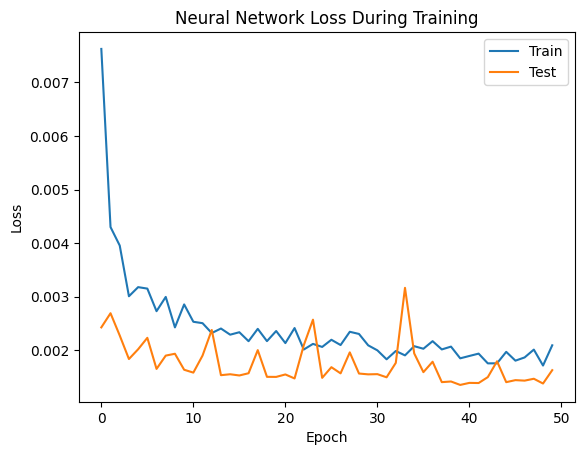

In [537]:
# Plotting the model's training and validation loss over the training period
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Neural Network Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Testing the Model

In [549]:
# unscaled_data = scaler.inverse_transform(scaled_data)
# unscaled_data

array([[1.78350000e+04, 1.97649002e+02, 1.98337997e+02, ...,
        1.97380997e+02, 1.44238000e+09, 2.00186005e+02],
       [1.78360000e+04, 1.97537003e+02, 2.03753998e+02, ...,
        1.98871994e+02, 1.33670000e+09, 2.07485992e+02],
       [1.78370000e+04, 1.98981995e+02, 2.01268997e+02, ...,
        2.00634995e+02, 1.45187000e+09, 2.09091003e+02],
       ...,
       [1.96560000e+04, 1.78748193e+03, 1.86509522e+03, ...,
        1.80403931e+03, 1.11966726e+10, 1.79554602e+03],
       [1.96570000e+04, 1.80379492e+03, 1.80413586e+03, ...,
        1.78004529e+03, 7.49339977e+09, 1.81008862e+03],
       [1.96580000e+04, 1.78008423e+03, 1.80060535e+03, ...,
        1.77661816e+03, 4.22611273e+09, 1.81645898e+03]])

In [554]:
# unscaled_test_set = unscaled_data[train_data_len:, :]
# x_test_unscaled, y_test_unscaled = create_datasets(unscaled_test_set, TIMESTEP, INPUT_COLS, OUTPUT_COLS)
# y_test_unscaled.shape

(350,)

In [560]:
# Predicting the future price using the neural network
predictions = model.predict(x_test)
y_test_reshaped = y_test.reshape(-1, 1)  # Reshape if needed

# Calculate mean squared error
mse = mean_squared_error(y_test_reshaped, predictions)

# Calculate R-squared
r2 = r2_score(y_test_reshaped, predictions)

# Print the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

11/11 [==============================] - 0s 11ms/step
Mean Squared Error (MSE): 0.0002665875764349173
R-squared (R2): 0.8854609620313673


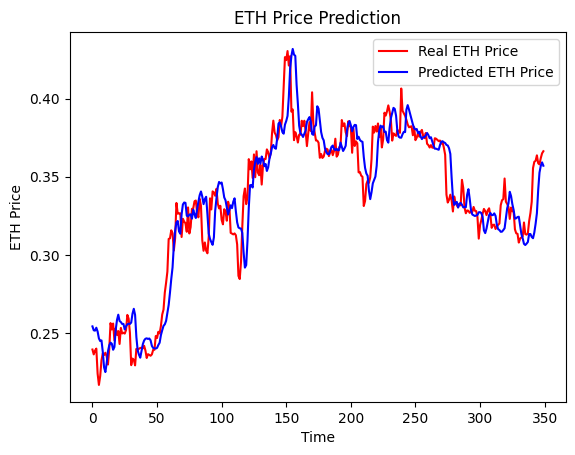

In [562]:
# Plotting the model's accuracy
plt.plot(y_test, color = 'red', label = "Real ETH Price")
plt.plot(predictions, color = 'blue', label = "Predicted ETH Price")
plt.title("ETH Price Prediction")
plt.xlabel('Time')
plt.ylabel('ETH Price')
plt.legend()
plt.show()

In [ ]:
Accuracy here turned out 